### Одноклассовый классификатор на основе трехслойного автоэнкодера

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.bool = np.bool_
np.int = np.int_
np.object = np.object_
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

#### Загрузка данных

In [3]:
normal_train_data = tf.convert_to_tensor(np.load('normal_train_data.npy'))
normal_test_data = tf.convert_to_tensor(np.load('normal_test_data.npy'))
anomalous_train_data = tf.convert_to_tensor(np.load('anomalous_train_data.npy'))
anomalous_test_data = tf.convert_to_tensor(np.load('anomalous_test_data.npy'))
train_data = tf.convert_to_tensor(np.load('train_data.npy'))
test_data = tf.convert_to_tensor(np.load('test_data.npy'))
train_labels = tf.convert_to_tensor(np.load('train_labels.npy'))
test_labels = tf.convert_to_tensor(np.load('test_labels.npy'))

In [4]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([4, 8, 16, 32, 64]))


class AnomalyDetector(Model):
  def __init__(self, hp):
    super(AnomalyDetector, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Dense(hp, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

  
def model_builder(hp):
  
  hp_units = hp.Int('units', min_value=4, max_value=64, step=5)
  model = AnomalyDetector(hp_units)
  model.compile(optimizer='adam', loss='mse', metrics= ["mse"])

  return model

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("mse", "min"),
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [6]:
tuner.search(normal_train_data, normal_train_data, epochs=30,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


INFO:tensorflow:Oracle triggered exit


In [16]:
best_hps.values

{'units': 64,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0205'}

In [7]:
autoencoder = tuner.hypermodel.build(best_hps)
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=30,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/30
5/5 [==============================] - 2s 28ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 8/30
5/5 [==============================] - 0s 7ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 

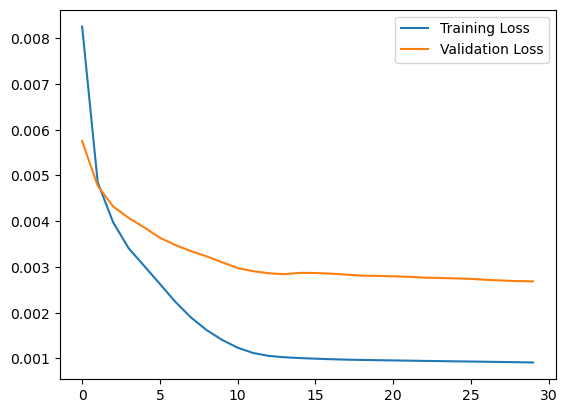

In [8]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

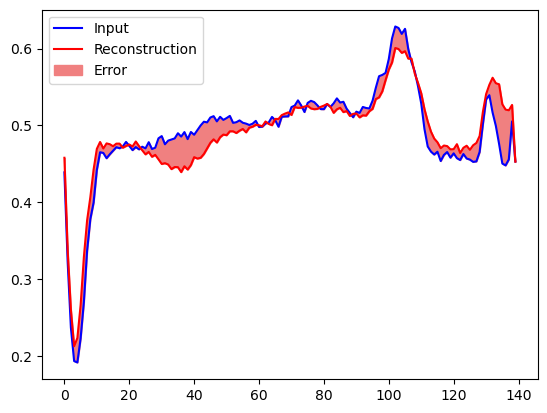

In [9]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

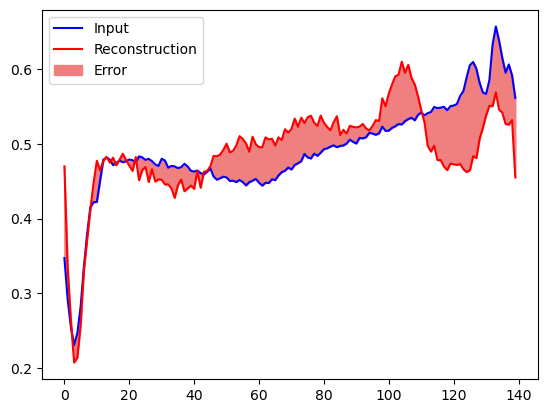

In [10]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

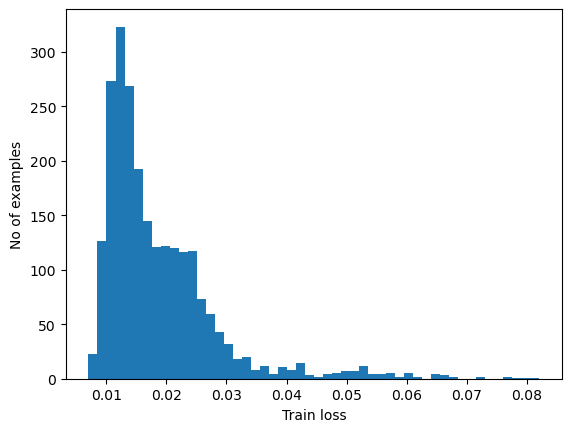

In [11]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [12]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.028549746


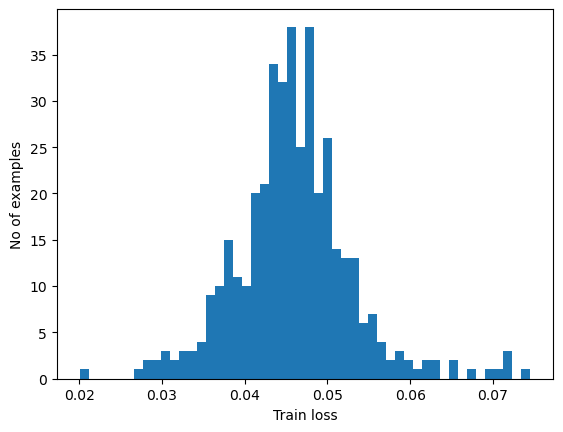

In [13]:
reconstructions = autoencoder.predict(anomalous_test_data)
train_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    # Calculate overall accuracy
    accuracy = accuracy_score(labels, predictions)
    print("Overall Accuracy = {:.2f}".format(accuracy))
    # Print the classification report for a detailed view
    print("\nClassification Report:")
    print(classification_report(labels, predictions))

Overall Accuracy = 0.93

Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.99      0.92       408
        True       0.99      0.88      0.93       592

    accuracy                           0.93      1000
   macro avg       0.92      0.94      0.92      1000
weighted avg       0.94      0.93      0.93      1000



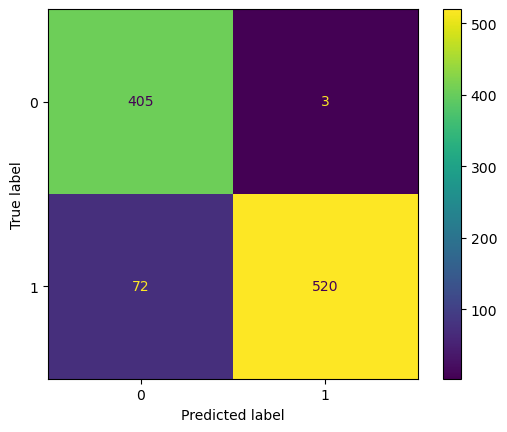

In [15]:
preds = predict(autoencoder, test_data, threshold)

print_stats(preds, test_labels)
ConfusionMatrixDisplay(confusion_matrix(test_labels, preds)).plot()